## Proyecto del Día 13 - Juego de Navegación en un Laberinto

Este proyecto tiene como objetivo desarrollar un entorno de laberinto simple y aplicar un algoritmo de **Aprendizaje por Refuerzo** para enseñar a una IA a navegar desde un punto inicial hasta un objetivo.

Dada la naturaleza de este proyecto, considero que el algoritmo más adecuado para este tipo de probleas es **Q-Learning**, por su facilidad de implelentación y comprensión, su estabilidad y su relación entre la exploración y la explotación.

Por esa razón te propongo resolverlo usando ese algoritmo, aunque dejo a tu criterio si quieres resolverlo con otro algoritmo de tu elección. Siempre estaré a favor de que investigues, y expandas las habilidades propuestas por tu cuenta.

### Descripción del Laberinto:

El laberinto se representa como una matriz de dos dimensiones, donde cada elemento puede ser:
+ un camino libre (0)
+ un obstáculo (1)
+ el objetivo (G)

La tarea es desarrollar un agente que pueda aprender a encontrar el camino desde un punto de inicio hasta el objetivo evitando obstáculos.


### Creación del Laberinto

Debido a que el desafío de hoy es bastante complejo, y que el objetivo final no se trata de que sepas desarrollar laberintos, sino sistemas para resolverlos, voy a facilitar la tarea entregando en este cuaderno el código para generar nuestros laberintos.

Tu parte será la siguiente, que es diseñar y entrenar un modelo de Q-Learning para resolver el laberinto de la manera mpas eficiente, y luego mostrar una visualización sobre cómo lo ha hecho.

Te deseo toda la suerte del mundo, y sobre todo, que te diviertas de a montones.

In [68]:
# Librerías necesarias para todo el ejercicio
import numpy as np
import matplotlib.pyplot as plt
import random

In [69]:
# Función para crear el laberinto
def crear_laberinto(tamanio, porcentaje_paredes=20, inicio=(0, 0), meta=None):
    laberinto = np.zeros((tamanio, tamanio))
    numero_paredes = int((tamanio * tamanio) * porcentaje_paredes / 100)
    
    # Ubicar paredes
    for pared in range(numero_paredes):
        x, y = random.randint(0, tamanio-1), random.randint(0, tamanio-1)
        
        # Cuidar que inicio y meta no sean paredes
        if (x, y) != inicio and (meta is None or (x, y) != meta):
            laberinto[x, y] = 1
            
    # Ubicar la meta
    if meta:
        laberinto[meta] = 9  # Representa la meta con 9
    else:
        # Ubicar la meta aleatoriamente si no está especificado
        while True:
            x, y = random.randint(0, tamanio-1), random.randint(0, tamanio-1)
            if laberinto[x, y] == 0 and (x, y) != inicio:
                laberinto[x, y] = 9
                break
    
    return laberinto

In [70]:
# Función para visualizar el laberinto
def ver_laberinto(laberinto):
    plt.figure(figsize=(5, 5))
    plt.imshow(laberinto, cmap='hot', interpolation='nearest')
    plt.colorbar();

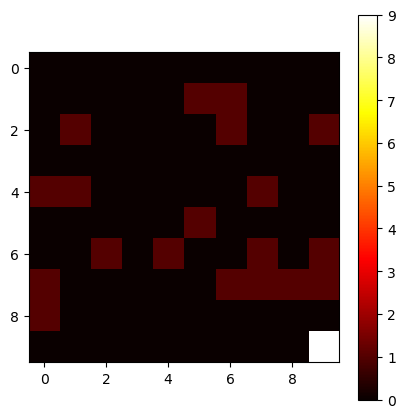

In [71]:
# Ejemplo de crear y mostrar laberintos
laberinto = crear_laberinto(10, 20, inicio=(0, 0), meta=(9, 9))
ver_laberinto(laberinto)

### Ahora te toca a ti

Lo que sigue es implementar todo el código para que un algoritmo de Q-Learning encuentre la manera más eficiente de llegar a la meta. Voy a dejarte los pasos que considero que son los necesarios para lograrlo

##### 1. Parámetros para el algoritmo Q-Learning

In [72]:
laberinto

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 1., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 1., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 1., 0., 0., 1., 0., 1.],
       [1., 0., 0., 0., 0., 0., 1., 1., 1., 1.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 9.]])

In [73]:
def obtener_obstaculos(laberinto):
    return [
        (i, j)
        for i, fila in enumerate(laberinto)
        for j, valor in enumerate(fila)
        if valor == 1
    ]


In [74]:
dimensiones = (10,10)
estado_inicial = (0,0)
estado_objetivo = (9,9)
obstaculos = obtener_obstaculos(laberinto)
num_estados = dimensiones[0] * dimensiones[1]

# Cada acción es una tupla (Δfila, Δcolumna).
acciones = [(-1, 0), (1, 0), (0, -1), (0, 1)]
num_acciones = len(acciones)

Q = np.zeros((num_estados, num_acciones))

alpha = 0.1
gamma = 0.99
epsilon = 0.2
episodios = 100

##### 2. Función para convertir coordenadas a índice lineal

In [75]:
def estado_a_indice(estado):
    return estado[0] * dimensiones[1] + estado[1]

##### 3. Función para elegir acciones equilibrando entre explotación y exploración

In [76]:
def elegir_accion(estado):
    if random.uniform(0, 1) < epsilon:
        return random.choice(range(0, num_acciones)) 
    else:
        return np.argmax(Q[estado_a_indice(estado)])

##### 4. Función para simular la acción en el laberinto

In [77]:
def aplicar_accion(estado, accion_idx):
    accion = acciones[accion_idx]
    nuevo_estado = (estado[0] + accion[0], estado[1] + accion[1])

    # Verificar que no salga del laberinto
    if not (0 <= nuevo_estado[0] < dimensiones[0] and 0 <= nuevo_estado[1] < dimensiones[1]):
        return estado, -100, False  # Golpe contra un borde
    
    if nuevo_estado in obstaculos:
        return estado, -100, False 

    if nuevo_estado == estado_objetivo:
        return nuevo_estado, 100, True 

    return nuevo_estado, -1, False


##### 5. Función principal para ejecutar el algoritmo Q-Learning

In [78]:
def funcion():

    for episodio in range(episodios):

        estado = estado_inicial
        terminado = False

        while not terminado:

            idx_estado = estado_a_indice(estado)

            accion_idx = elegir_accion(estado)

            nuevo_estado, recompensa, terminado = aplicar_accion(estado, accion_idx)

            idx_nuevo_estado = estado_a_indice(nuevo_estado)

            Q[idx_estado, accion_idx] = Q[idx_estado, accion_idx] + alpha * (recompensa + gamma * np.max(Q[idx_nuevo_estado]) - Q[idx_estado, accion_idx])

            estado = nuevo_estado

##### 6. Iniciar el laberinto y configurar el algoritmo Q-Learning

In [79]:
funcion()

##### 7. Función para mostrar el aprendizaje del agente

In [80]:
def mostrar_q_table():
    print("Tabla Q (valores por estado y acción):")
    for fila in range(dimensiones[0]):
        for col in range(dimensiones[1]):
            estado = (fila, col)
            idx = estado_a_indice(estado)
            print(f"Estado {estado} ({idx}): {Q[idx]}")

mostrar_q_table()

Tabla Q (valores por estado y acción):
Estado (0, 0) (0): [-83.30119262  -6.95648024 -87.51148652  -6.96334217]
Estado (0, 1) (1): [-73.93604664  -6.47290864  -6.49134172  -6.41321093]
Estado (0, 2) (2): [-66.74376053  -5.90660754  -6.01930699  -5.92591825]
Estado (0, 3) (3): [-71.1337136   -5.49894605  -5.52598161  -5.55454717]
Estado (0, 4) (4): [-66.78937181  -5.27378437  -5.27043584  -5.27326354]
Estado (0, 5) (5): [-62.70995153 -58.25522456  -5.08380285  -5.04718861]
Estado (0, 6) (6): [-53.32311185 -27.36789607  -4.83105781  -4.86667292]
Estado (0, 7) (7): [-83.52733985  -4.54311036  -4.67599946  -4.48941397]
Estado (0, 8) (8): [-62.59646098  -4.35353025  -4.39337283  -4.36759306]
Estado (0, 9) (9): [-47.88814924  -4.2540783   -4.31679073 -27.48829391]
Estado (1, 0) (10): [ -6.49072679  -6.49488417 -67.26323174  -6.48787284]
Estado (1, 1) (11): [ -6.2008968  -66.99600091  -6.30276654  -6.20046183]
Estado (1, 2) (12): [-5.73532461 -5.6421263  -5.79521773 -5.70483478]
Estado (1, 3)

##### 8. Visualizar el resultado

In [81]:
def mostrar_politica():
    simbolos_accion = {
        0: '↑',   # (-1, 0)
        1: '↓',   # (1, 0)
        2: '←',   # (0, -1)
        3: '→'    # (0, 1)
    }

    print("\nPolítica aprendida (mejor acción por estado):\n")
    for fila in range(dimensiones[0]):
        linea = ""
        for col in range(dimensiones[1]):
            estado = (fila, col)
            if estado in obstaculos:
                linea += " ⛔ "  # obstáculo
            elif estado == estado_objetivo:
                linea += " 🎯 "  # objetivo
            else:
                idx = estado_a_indice(estado)
                mejor_accion = np.argmax(Q[idx])
                linea += f" {simbolos_accion[mejor_accion]}  "
        print(linea)

mostrar_politica()


Política aprendida (mejor acción por estado):

 ↓   →   ↓   ↓   ←   →   ←   →   ↓   ↓  
 →   →   ↓   ↑   ↓   ⛔  ⛔  ↓   →   ↑  
 ↑   ⛔  →   ↓   →   ↓   ⛔  →   ←   ⛔ 
 ↑   ←   →   ↓   ↓   ←   ↓   ↑   →   ←  
 ⛔  ⛔  ↓   ↓   ←   →   ↓   ⛔  →   ←  
 ↓   ←   →   ↓   ←   ⛔  ↓   ←   →   ↑  
 ↑   ↑   ⛔  ↓   ⛔  ↓   ←   ⛔  ↑   ⛔ 
 ⛔  →   ↓   ↓   ↓   ↓   ⛔  ⛔  ⛔  ⛔ 
 ⛔  →   →   →   →   ↓   ↓   →   ↓   ↓  
 →   ↑   →   →   →   →   →   →   →   🎯 
